In [1]:
import numpy as np
import pandas as pd

In [11]:
sales_data = pd.read_excel('C:/Users/michelj8/Downloads/Sales_Transactions_Dataset_Weekly.xlsx',sheet_name = 'Sheet1')
sales_data = sales_data.set_index('Product_Code')

In [16]:
def exp_smooth(Y,alpha):
    smooth = [Y[1]]
    for t in range(1, len(Y)):
        smooth.append( (1-alpha)*Y[t] + (alpha)* smooth[t-1])    
    return smooth

def objective(Y,alpha,penalty):
    data = pd.DataFrame({'Y':Y, 'est':exp_smooth(Y,alpha)})
    data['est'] = data['est'].shift(1)
    data = data.dropna()
    
    sum_squares = np.square(data['Y'] - data['est']).sum() + penalty*abs(alpha)
    return sum_squares

def minimal_alpha(Y, penalty):
    obj_df = pd.DataFrame(columns = ['alpha','value'])
    
    obj_df['alpha'] = np.linspace(0,1,100)
    obj_df['value'] = obj_df['alpha'].apply(lambda s: objective(Y,s,penalty))
    
    min_val = obj_df['value'].min()
    return obj_df.set_index('value').loc[min_val,'alpha']

# Alpha SES for all data

In [30]:
alpha_df = pd.DataFrame( columns = ['product','alpha'])
alpha_df['product'] = sales_data.index.values
alpha_df['alpha'] = alpha_df['product'].apply(lambda s: minimal_alpha(sales_data.loc[s],0.0) )

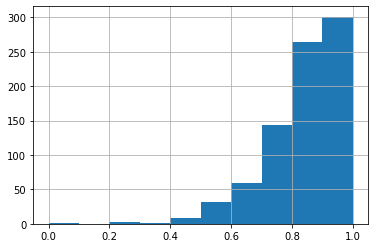

In [34]:
alpha_df['alpha'].hist()

In [37]:
len(alpha_df.query('alpha < .5'))/len(alpha_df)

0.016029593094944512

# LASSO Analysis for 1

In [194]:
# Y = sales_data.loc['P500']
# sample_size = len(Y)

# Y_train = Y[0:round(sample_size/2.5)].values
# Y_validate = Y[round(sample_size/2.5):2*round(sample_size/2.5)].values
# Y_test = Y[2*round(sample_size/2.5):].values

# train_index = range(0,round(sample_size/2.5))
# validate_index = range(round(sample_size/2.5), 2* round(sample_size/2.5))
# test_index = range(2*round(sample_size/2.5),sample_size)

# # penalty_list = np.linspace(0,750,10)
# penalty_list = np.linspace(0,450,50)

# cv_df = pd.DataFrame(columns =['penalty','train_alpha','validate_sse','test_sse'])
# cv_df['penalty'] = penalty_list
# cv_df = cv_df.set_index('penalty')

# for pen in penalty_list:
#     train_alpha = minimal_alpha(Y_train,pen)
    
#     exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
#     exp_df['exp'] = exp_df['exp'].shift(1) 
#     exp_df = exp_df.reset_index()
    
#     val_sse = np.square(exp_df.loc[validate_index]['Y'] - exp_df.loc[validate_index]['exp']).sum()
#     test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
    
#     cv_df.loc[pen] = [train_alpha,val_sse,test_sse]
    
# cv_df = cv_df.reset_index()

In [305]:
Y = sales_data.loc['P16']
sample_size = len(Y)

Y_train = Y[0:round(sample_size/2.5)].values
Y_validate = Y[round(sample_size/2.5):2*round(sample_size/2.5)].values
Y_test = Y[2*round(sample_size/2.5):].values

train_index = range(0,round(sample_size/2.5))
validate_index = range(round(sample_size/2.5), 2* round(sample_size/2.5))
test_index = range(2*round(sample_size/2.5),sample_size)

penalty_list = np.linspace(0,750,50)
# penalty_list = np.linspace(0,400,50)

cv_df = pd.DataFrame(columns =['penalty','train_alpha','validate_sse','test_sse'])
cv_df['penalty'] = penalty_list
cv_df = cv_df.set_index('penalty')

for pen in penalty_list:
    train_alpha = minimal_alpha(Y_train,pen)
    
    exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
    exp_df['exp'] = exp_df['exp'].shift(1) 
    exp_df = exp_df.reset_index()
    
    val_sse = np.square(exp_df.loc[validate_index]['Y'] - exp_df.loc[validate_index]['exp']).sum()
    test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
    
    cv_df.loc[pen] = [train_alpha,val_sse,test_sse]
    
cv_df = cv_df.reset_index()


opt_lambda = cv_df[cv_df['validate_sse']== cv_df['validate_sse'].min()]['penalty'].values[0]

alpha_list = []
oos_error_list = []
for pen in [0.0, opt_lambda]:
    train_alpha = minimal_alpha(np.append(Y_train,Y_validate),pen)
    
    exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
    exp_df['exp'] = exp_df['exp'].shift(1) 
    exp_df = exp_df.reset_index()
    test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
    
    alpha_list.append(train_alpha)
    oos_error_list.append(test_sse)

In [306]:
# print(alpha_list)
# print(oos_error_list)
outcome_df =  pd.DataFrame({'model':['exp_smooth','lasso'], 'alpha':alpha_list, 'sse':oos_error_list})
outcome_df.set_index('model')

,alpha,sse
model,,
exp_smooth,0.626263,532.697345
lasso,0.575758,517.583390


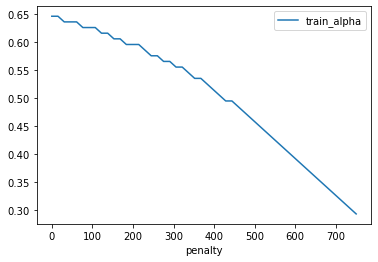

In [307]:
cv_df.plot(x = 'penalty',y='train_alpha')

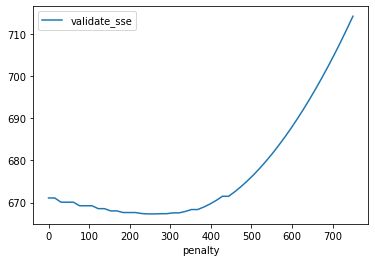

In [308]:
cv_df.plot(x = 'penalty', y='validate_sse')

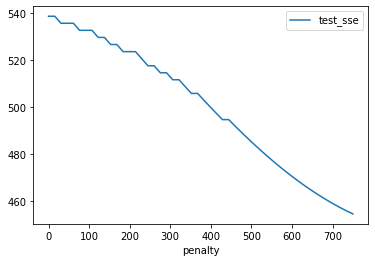

In [309]:
cv_df.plot(x = 'penalty',y='test_sse')

In [310]:
# opt_lambda = cv_df[cv_df['validate_sse']== cv_df['validate_sse'].min()]['penalty'].values[0]

# print('SES test data is ', cv_df.query('penalty == 0.0')['test_sse'].values[0])
# print('CV lasso test data is ', cv_df.query('penalty == @opt_lambda')['test_sse'].values[0])

In [311]:
cv_df

,penalty,train_alpha,validate_sse,test_sse
0,0.000000,0.646465,671.099,538.695
1,15.306122,0.646465,671.099,538.695
2,30.612245,0.636364,670.1,535.707
3,45.918367,0.636364,670.1,535.707
4,61.224490,0.636364,670.1,535.707
5,76.530612,0.626263,669.255,532.697
6,91.836735,0.626263,669.255,532.697
7,107.142857,0.626263,669.255,532.697
8,122.448980,0.616162,668.566,529.674
9,137.755102,0.616162,668.566,529.674


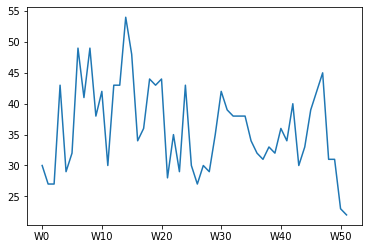

In [312]:
Y.plot()

In [350]:
test_df = pd.DataFrame(columns = ['alpha_ses','alpha_lasso','opt_lambda','sse_ses','sse_lasso'])


for prod in sales_data.index.values:
    Y = sales_data.loc[prod]
    sample_size = len(Y)

    Y_train = Y[0:round(sample_size/2.5)].values
    Y_validate = Y[round(sample_size/2.5):2*round(sample_size/2.5)].values
    Y_test = Y[2*round(sample_size/2.5):].values

    train_index = range(0,round(sample_size/2.5))
    validate_index = range(round(sample_size/2.5), 2* round(sample_size/2.5))
    test_index = range(2*round(sample_size/2.5),sample_size)

    penalty_list = np.linspace(0,750,50)
    # penalty_list = np.linspace(0,400,50)

    cv_df = pd.DataFrame(columns =['penalty','train_alpha','validate_sse','test_sse'])
    cv_df['penalty'] = penalty_list
    cv_df = cv_df.set_index('penalty')

    for pen in penalty_list:
        train_alpha = minimal_alpha(Y_train,pen)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()

        val_sse = np.square(exp_df.loc[validate_index]['Y'] - exp_df.loc[validate_index]['exp']).sum()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        cv_df.loc[pen] = [train_alpha,val_sse,test_sse]

    cv_df = cv_df.reset_index()


    opt_lambda = cv_df[cv_df['validate_sse']== cv_df['validate_sse'].min()]['penalty'].values[0]

    alpha_list = []
    oos_error_list = []
    for pen in [0.0, opt_lambda]:
        train_alpha = minimal_alpha(np.append(Y_train,Y_validate),pen)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        alpha_list.append(train_alpha)
        oos_error_list.append(test_sse)

    
    test_df.loc[prod] = alpha_list +[opt_lambda] +oos_error_list

KeyboardInterrupt: 

In [353]:
test_df.head()

,alpha_ses,alpha_lasso,opt_lambda,sse_ses,sse_lasso
P1,0.878788,0.868687,45.918367,119.083685,119.266320
P2,0.878788,0.878788,0.000000,53.015910,53.015910
P3,0.909091,0.909091,0.000000,104.553392,104.553392
P4,1.000000,1.000000,0.000000,87.000000,87.000000
P5,0.777778,0.757576,45.918367,73.807881,74.581186


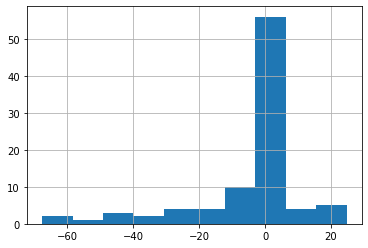

In [354]:
test_df['sse_delta'] = (test_df['sse_ses'] - test_df['sse_lasso'])
test_df['sse_delta'].hist()

In [355]:
len(test_df.query('sse_delta < 0'))/len(test_df)

0.3956043956043956

In [356]:
len(test_df.query('sse_delta == 0'))/len(test_df)

0.45054945054945056

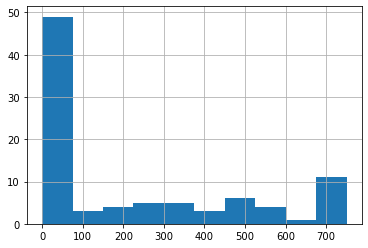

In [357]:
test_df['opt_lambda'].hist()

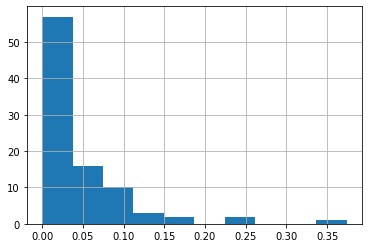

In [358]:
(test_df['alpha_ses'] - test_df['alpha_lasso']).hist()

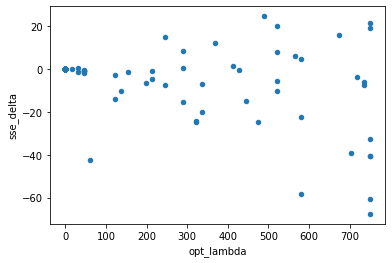

In [359]:
test_df.plot.scatter(x='opt_lambda',y='sse_delta')